In [1]:
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
np.set_printoptions(precision=3)
import sys
sys.path.append('../../zdrojaky')
from tsplot import tsplot

# from statsmodels.tsa.api import acf, graphics, pacf
from statsmodels.tsa.ar_model import AutoReg, ar_select_order

import warnings
warnings.simplefilter(action='ignore', category=(FutureWarning, DeprecationWarning))

# Modelování časové řady COVID-19 pomocí AR modelu

*Zdroj dat: https://onemocneni-aktualne.mzcr.cz/api/v2/covid-19*

Uvažujme datovou sadu poskytovanou MZ ČR s následujícím popisem:

```Obsahem je komplexní přehled základních epidemiologických parametrů (počty diagnostikovaných osob s COVID-19, počty aktuálně nakažených, hospitalizovaní pacienti) se zaměřením na seniorní zranitelné skupiny obyvatel (kategorie věku 65+, 75+) na geografické úrovni obcí s rozšířenou působností (ORP).```

Data si stáhneme a prozkoumáme její obsah. Schema CSV je podle poskytovatele následující:

```
den:string
datum:date
orp_kod:string
orp_nazev:string
incidence_7:integer
incidence_65_7:integer
incidence_75_7:integer
prevalence:integer
prevalence_65:integer
prevalence_75:integer
aktualni_pocet_hospitalizovanych_osob:integer
nove_hosp_7:integer
testy_7:integer
```

In [16]:
fn = 'https://onemocneni-aktualne.mzcr.cz/api/v2/covid-19/orp.csv'
data = pd.read_csv(fn, index_col=1, parse_dates=True, infer_datetime_format=True)
data.head()

,den,orp_kod,orp_nazev,incidence_7,incidence_65_7,incidence_75_7,prevalence,prevalence_65,prevalence_75,aktualni_pocet_hospitalizovanych_osob,nove_hosp_7,testy_7
datum,,,,,,,,,,,,
2020-03-01,neděle,0,Praha,2,1,0,2,1,0,0,0,0
2020-03-02,pondělí,0,Praha,2,1,0,2,1,0,0,0,0
2020-03-03,úterý,0,Praha,3,1,0,3,1,0,0,0,2
2020-03-04,středa,0,Praha,4,1,0,4,1,0,0,0,4
2020-03-05,čtvrtek,0,Praha,4,1,0,4,1,0,0,0,6


Budeme si vybírat konkrétní ORP (obec s rozšířenou působností) a v ní jen určitou část období (proč?). Vykreslíme si průběh vybrané řady a ACF s PACF:

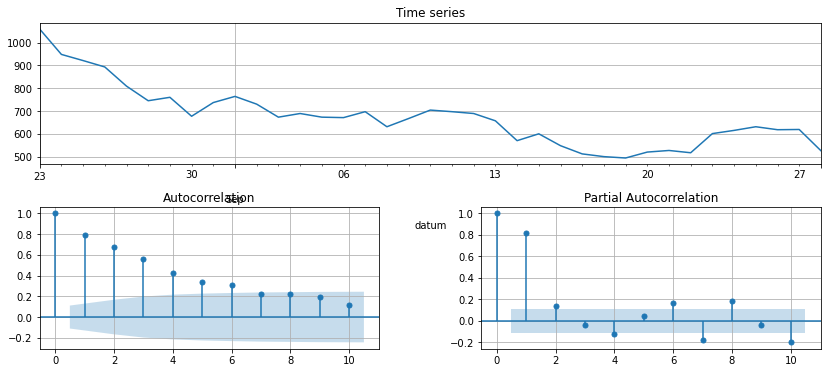

In [25]:
df = data.loc[data['orp_nazev']=='Most']
df_analysis = df['testy_7'].last('6W')
df_analysis = df_analysis.asfreq('D')

tsplot(df_analysis, lags=10)

Pokud má časová řada vlastnosti autoregresního modelu, tj. lze ji modelovat v podobě

$$
X_t = c + \phi_1 X_{t-1} + \ldots + \phi_p X_{t-p} + \varepsilon_t, \qquad \varepsilon_t \sim \mathrm{WN}(0, \sigma^2),
$$

kde $\mathrm{WN}(0, \sigma^2)$ reprezentuje bílý (ne nutně normální) šum s nulovou střední hodnotou a konstantní variancí, můžeme se pokusit nasadit AR model vhodného řádu. Ten potřebujeme nějakým způsobem odhadnout, můžeme využít např. metodu `ar_select_order()`, nebo prostě pokus-omyl :)

Jednou z možností, jak vybrat vhodný model z více kandidátů je poměřit jejich "kvalitu" vhodným **informačním kritériem**. Nejpopulárnější dvě jsou následující:

#### AIC - [Akaikeho informační kritérium](https://en.wikipedia.org/wiki/Akaike_information_criterion)

Označme počet odhadovaných parametrů $k$ a maximální hodnotu věrohodnosti při daném modelu $\mathcal{L}$. Potom kritérium je číslo

$$
\mathrm{AIC} = 2k - 2\ln \mathcal{L}.
$$

Kritérium je asymptoticky ekvivalentní ke křížové validaci.

#### BIC - [Bayesovské informační kritérium](https://en.wikipedia.org/wiki/Bayesian_information_criterion)

Označme navíc počet pozorování $n$. Potom kritériem je číslo

$$
\mathrm{BIC} = k \ln(n) - 2\ln \mathcal{L}.
$$

V zásadě je jedno, ke kterému se přikloníme, obě mají své výhody a nevýhody, viz články na příslušných odkazech. Ať už vybíráme podle informačního kritéria nebo jinak, v každém případě platí, že **při srovnatelné kvalitě preferujeme modely jednodušší před komplexnějšími**.

In [30]:
from statsmodels.tsa.ar_model import AutoReg, ar_select_order
out = ar_select_order(df_analysis, maxlag=10, ic='bic', trend='c')
print(f'Vhodné řády: {out.ar_lags}')

Vhodné řády: [1]


Máme-li vybrán vhodný řád, můžeme fitovat. A možná i poté zkusíme s řádem či přítomností konstanty trochu pracovat. Zejména můžeme studovat, co se děje s informačním kritériem, jak dopadají testy koeficientů a jak je to s kořeny charakteristické rovnice:

In [47]:
model = AutoReg(df_analysis, lags=1, trend='c')
res = model.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            AutoReg Model Results                             
==============================================================================
Dep. Variable:                testy_7   No. Observations:                   37
Model:                     AutoReg(1)   Log Likelihood                -186.727
Method:               Conditional MLE   S.D. of innovations             43.290
Date:                Tue, 28 Sep 2021   AIC                              7.647
Time:                        13:09:14   BIC                              7.735
Sample:                    08-24-2021   HQIC                             7.678
                         - 09-28-2021                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
testy_7.L1     0.9729      0.010     92.877      0.000       0.952       0.993
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.0278           +0.0000j            1.0278            0.0000
-----------------------------------------------------------------------------
"""

Zajímat nás budou rovněž rezidua, tj. rozdíly mezi modelem predikovanými hodnotami a hodnotami skutečnými. Rádi bychom viděli absenci heteroskedasticity (tj. chceme neměnný rozptyl), vlastnosti blízké gaussovce a jejich nekorelovanost (proč?).

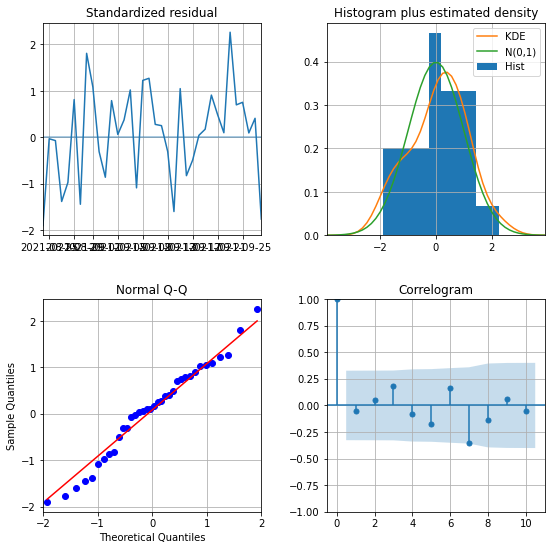

In [48]:
res.plot_diagnostics(figsize=(9,9))
plt.show()

Cílem modelování je často předpovídání budoucích hodnot. Zkusíme jak predikci uvnitř dat (in-sample prediction), tak vně (out-of-sample, tj. forecasting). Může být výhodné brát data rovnou z modelu:

In [49]:
res.data.orig_endog[0:10]

datum
2021-08-23    1059
2021-08-24     948
2021-08-25     921
2021-08-26     893
2021-08-27     809
2021-08-28     745
2021-08-29     760
2021-08-30     677
2021-08-31     737
2021-09-01     764
Freq: D, Name: testy_7, dtype: int64

/home/jp/anaconda3/envs/fit/lib/python3.9/site-packages/statsmodels/tsa/ar_model.py:2336: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = fig.add_subplot(111)


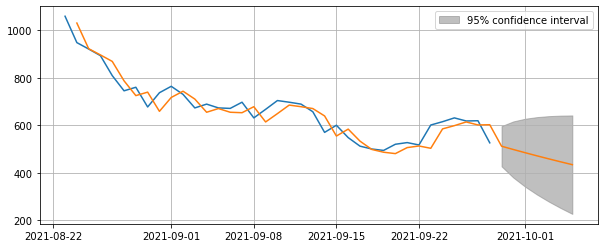

In [50]:
pred_from = 0
fcast_horizon = 7
fig = plt.figure(figsize=(10,4))
ax = fig.add_subplot(111)
ax.plot(res.data.orig_endog[pred_from:])
res.plot_predict(pred_from, res.model.nobs+fcast_horizon, fig=fig)
plt.show()

Řádně si prohlédněte výsledky a zamyslete se nad nimi. Co jsme získali oproti jiným známým metodám a co naopak ztrácíme?